In [1]:
import os
import sys
import math
import datetime

mainDir = os.path.dirname(os.path.abspath(""))
sys.path.append(mainDir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import QuantLib as ql

from matplotlib.ticker import PercentFormatter

from ir import *

A QuantLib-Python companion for the Ametrano-Bianchetti paper:
https://www.implementingquantlib.com/2023/09/ametrano-bianchetti.html

In [3]:
eoniaDataframe = pd.read_csv(
    os.path.abspath(os.path.join(mainDir, "data/eonia11122012.csv")),
    sep=';'
)
eoniaDataframe.head(10)

,Bootstrapping Instrument,"Rate, %",Start Date,End Date
0,EUR_YC_OND,0.040,Tue 11 Dec 2012,Wed 12 Dec 2012
1,EUR_YC_TND,0.040,Wed 12 Dec 2012,Thu 13 Dec 2012
2,EUR_YC_SND,0.040,Thu 13 Dec 2012,Fri 14 Dec 2012
3,EUR_YC_EONSW,0.070,Thu 13 Dec 2012,Thu 20 Dec 2012
4,EUR_YC_EON2W,0.069,Thu 13 Dec 2012,Thu 27 Dec 2012
5,EUR_YC_EON3W,0.078,Thu 13 Dec 2012,Thu 03 Jan 2013
6,EUR_YC_EON1M,0.074,Thu 13 Dec 2012,Mon 14 Jan 2013
7,EUR_YC_EONECBJan13,0.046,Wed 16 Jan 2013,Wed 13 Feb 2013
8,EUR_YC_EONECBFEB13,0.016,Wed 13 Feb 2013,Wed 13 Mar 2013
9,EUR_YC_EONECBMAR13,-0.007,Wed 13 Mar 2013,Wed 10 Apr 2013


In [4]:
eoniaDataframe['StartDate'] = eoniaDataframe['Start Date'].apply(
    lambda x: datetime.datetime.strptime(x, '%a %d %b %Y').date()
)

eoniaDataframe['EndDate'] = eoniaDataframe['End Date'].apply(
    lambda x: datetime.datetime.strptime(x, '%a %d %b %Y').date()
)

eoniaDataframe['Rate'] = eoniaDataframe['Rate, %'] / 100

eoniaDataframe.head()

,Bootstrapping Instrument,"Rate, %",Start Date,End Date,StartDate,EndDate,Rate
0,EUR_YC_OND,0.040,Tue 11 Dec 2012,Wed 12 Dec 2012,2012-12-11,2012-12-12,0.00040
1,EUR_YC_TND,0.040,Wed 12 Dec 2012,Thu 13 Dec 2012,2012-12-12,2012-12-13,0.00040
2,EUR_YC_SND,0.040,Thu 13 Dec 2012,Fri 14 Dec 2012,2012-12-13,2012-12-14,0.00040
3,EUR_YC_EONSW,0.070,Thu 13 Dec 2012,Thu 20 Dec 2012,2012-12-13,2012-12-20,0.00070
4,EUR_YC_EON2W,0.069,Thu 13 Dec 2012,Thu 27 Dec 2012,2012-12-13,2012-12-27,0.00069


# QuantLib case

In [62]:
today = ql.Date(11, ql.December, 2012)
ql.Settings.instance().evaluationDate = today

helpers = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
        ql.Period(1, ql.Days), # tenor
        fixingDays,
        ql.TARGET(),
        ql.Following,
        False,
        ql.Actual360(),
    )
    for rate, fixingDays in [(0.04, 0), (0.04, 1), (0.04, 2)]
]
eonia = ql.Eonia()
helpers += [
    ql.OISRateHelper(
        2, ql.Period(*tenor), ql.QuoteHandle(ql.SimpleQuote(rate / 100)), eonia
    )
    for rate, tenor in [
        (0.070, (1, ql.Weeks)),
        (0.069, (2, ql.Weeks)),
        (0.078, (3, ql.Weeks)),
        (0.074, (1, ql.Months)),
    ]
]
helpers += [
    ql.DatedOISRateHelper(
        start_date, end_date, ql.QuoteHandle(ql.SimpleQuote(rate / 100)), eonia
    )
    for rate, start_date, end_date in [
        (0.046, ql.Date(16, ql.January, 2013), ql.Date(13, ql.February, 2013)),
        (0.016, ql.Date(13, ql.February, 2013), ql.Date(13, ql.March, 2013)),
        (-0.007, ql.Date(13, ql.March, 2013), ql.Date(10, ql.April, 2013)),
        (-0.013, ql.Date(10, ql.April, 2013), ql.Date(8, ql.May, 2013)),
        (-0.014, ql.Date(8, ql.May, 2013), ql.Date(12, ql.June, 2013)),
    ]
]

helpers += [
    ql.OISRateHelper(
        2, ql.Period(*tenor), ql.QuoteHandle(ql.SimpleQuote(rate / 100)), eonia
    )
    for rate, tenor in [
        (0.002, (15, ql.Months)),
        (0.008, (18, ql.Months)),
        (0.021, (21, ql.Months)),
        (0.036, (2, ql.Years)),
        (0.127, (3, ql.Years)),
        (0.274, (4, ql.Years)),
        (0.456, (5, ql.Years)),
        (0.647, (6, ql.Years)),
        (0.827, (7, ql.Years)),
        (0.996, (8, ql.Years)),
        (1.147, (9, ql.Years)),
        (1.280, (10, ql.Years)),
        (1.404, (11, ql.Years)),
        (1.516, (12, ql.Years)),
        (1.764, (15, ql.Years)),
        (1.939, (20, ql.Years)),
        (2.003, (25, ql.Years)),
        (2.038, (30, ql.Years)),
    ]
]
eonia_curve_c = ql.PiecewiseLogLinearDiscount(
    0, ql.TARGET(), helpers, ql.Actual360()
)

eonia_curve_c.enableExtrapolation()
print(list(eonia_curve_c.dates()))
for d in list(eonia_curve_c.dates()):
    print(f"{d.to_date()}: {eonia_curve_c.discount(d)}")

[Date(11,12,2012), Date(12,12,2012), Date(13,12,2012), Date(14,12,2012), Date(20,12,2012), Date(27,12,2012), Date(3,1,2013), Date(14,1,2013), Date(13,2,2013), Date(13,3,2013), Date(10,4,2013), Date(8,5,2013), Date(12,6,2013), Date(13,3,2014), Date(13,6,2014), Date(15,9,2014), Date(15,12,2014), Date(14,12,2015), Date(13,12,2016), Date(13,12,2017), Date(13,12,2018), Date(13,12,2019), Date(14,12,2020), Date(13,12,2021), Date(13,12,2022), Date(13,12,2023), Date(13,12,2024), Date(13,12,2027), Date(13,12,2032), Date(14,12,2037), Date(15,12,2042)]
2012-12-11: 1.0
2012-12-12: 0.9999988888901234
2012-12-13: 0.9999977777814815
2012-12-14: 0.999996666674074
2012-12-20: 0.9999841668858673
2012-12-27: 0.9999709452277842
2013-01-03: 0.9999522799527306
2013-01-14: 0.9999320044764994
2013-02-13: 0.9998936751699755
2013-03-13: 0.9998812322035303
2013-04-10: 0.9998866760309887
2013-05-08: 0.9998967860984925
2013-06-12: 0.9999103959899934
2014-03-13: 0.9999725011551575
2014-06-13: 0.99987623587939
2014-0

C:\Users\Roman\AppData\Local\Temp\ipykernel_20776\2147697925.py:18: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date([d.to_date() for d in datesToPlot], rates_c, "-");


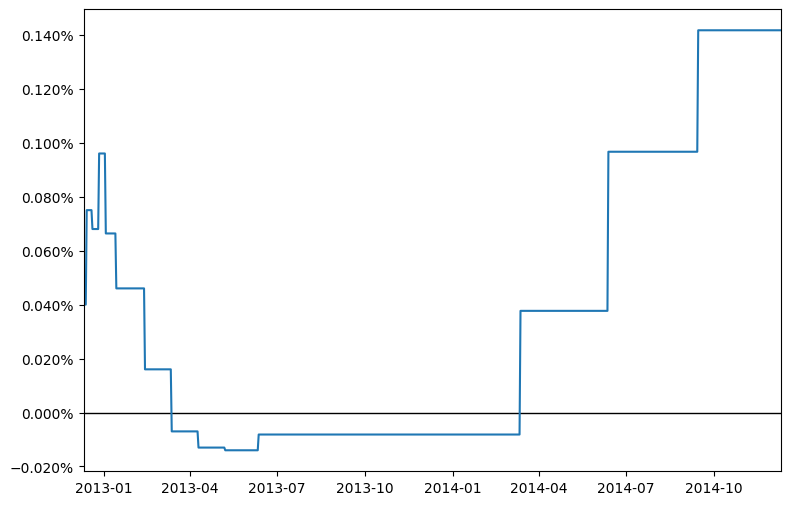

In [41]:
today = eonia_curve_c.referenceDate()
end = today + ql.Period(2, ql.Years)
datesToPlot = [
    ql.Date(serial)
    for serial in range(today.serialNumber(), end.serialNumber() + 1)
]
rates_c = [
    eonia_curve_c.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in datesToPlot
]

ax = plt.figure(figsize=(9, 6)).add_subplot(1, 1, 1)
ax.axhline(0.0, linewidth=1, color="black")
ax.set_xlim(min(datesToPlot).to_date(), max(datesToPlot).to_date())
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.plot_date([d.to_date() for d in datesToPlot], rates_c, "-");

Note. Why in article IRS fixed leg convention is 30/360?

# Own

In [43]:
todayDate = eoniaDataframe.StartDate[0]
spotDate = todayDate + Period('2D')

stubPeriod = ShortBack()
calendar = TargetCalendar()
businessDayConvention=Following()
endOfMonth = False
dayCounter = Act360()
dates = [todayDate] + eoniaDataframe["EndDate"].tolist()

initialNodes = {_date: 1 for _date in dates}
initialCurve = DiscountCurve(
    dates=list(initialNodes.keys()),
    discountFactors=list(initialNodes.values()),
    dayCounter=Act360()
)


# deposits
swaps = [
    Deposit(
        curve=initialCurve,
        fixedRate=rate,
        effectiveDate=effectiveDate,
        tenor='1D',
        endOfMonth=endOfMonth,
        businessDayConvention=businessDayConvention,
        dayCounter=dayCounter,
        stubPeriod=stubPeriod,
        calendar=calendar,
        notional=1.
    )
    for rate, effectiveDate, terminationDate in zip(
        eoniaDataframe.Rate[:3].tolist(),
        dates[:3],
        dates[1:4]
    )
]

# from 1W to 1M OIS
swaps += [
    InterestRateSwap(
        curve=initialCurve,
        fixedRate=rate,
        effectiveDate=spotDate,
        terminationDate=terminationDate,
        fixFrequency='1Y',
        floatFrequency='1Y',
        endOfMonth=endOfMonth,
        businessDayConvention=businessDayConvention,
        dayCounter=dayCounter,
        stubPeriod=stubPeriod,
        calendar=calendar,
        notional=1.
    )
    for rate, tenor, terminationDate in zip(
        eoniaDataframe.Rate[3:7].tolist(),
        ['1W', '2W', '3W', '1M'],
        dates[4:8]
    )
]

# forward start OIS
swaps += [
    InterestRateSwap(
        curve=initialCurve,
        fixedRate=rate,
        effectiveDate=startDate,
        terminationDate=endDate,
        fixFrequency='1Y',
        floatFrequency='1Y',
        endOfMonth=endOfMonth,
        businessDayConvention=businessDayConvention,
        dayCounter=dayCounter,
        stubPeriod=stubPeriod,
        calendar=calendar,
        notional=1.
    )
    for startDate, endDate, rate in zip(
        eoniaDataframe["StartDate"][7:12],
        eoniaDataframe["EndDate"][7:12],
        eoniaDataframe["Rate"][7:12]
    )
]

# common OIS
swaps += [
    InterestRateSwap(
        curve=initialCurve,
        fixedRate=rate,
        effectiveDate=startDate,
        terminationDate=endDate,
        fixFrequency='1Y',
        floatFrequency='1Y',
        endOfMonth=endOfMonth,
        businessDayConvention=businessDayConvention,
        dayCounter=dayCounter,
        stubPeriod=stubPeriod,
        calendar=calendar,
        notional=1.
    )
    for startDate, endDate, rate in zip(
        eoniaDataframe["StartDate"][12:],
        eoniaDataframe["EndDate"][12:],
        eoniaDataframe["Rate"][12:]
    )
]

curve, convergenceStatus = CurveBootstrapping(
    initialGuessNodes=initialNodes,
    swaps=swaps,
    dayCounter=dayCounter,
    curveInterpolator=LogLinearInterpolator
).solve()

print(curve)


    DiscountCurve|Act360|LogLinearInterpolator 
2012-12-11: 1.0 
2012-12-12: 0.9999988888901234 
2012-12-13: 0.9999977777814815 
2012-12-14: 0.999996666674074 
2012-12-20: 0.9999841668858767 
2012-12-27: 0.9999709452277843 
2013-01-03: 0.9999522799527437 
2013-01-14: 0.9999320044762979 
2013-02-13: 0.9998936751697738 
2013-03-13: 0.9998812322033286 
2013-04-10: 0.9998866760307871 
2013-05-08: 0.999896786098291 
2013-06-12: 0.9999103959897921 
2014-03-13: 0.9999725011124795 
2014-06-13: 0.9998762311168151 
2014-09-15: 0.9996239318602393 
2014-12-15: 0.9992660646188305 
2015-12-14: 0.9961373053645628 
2016-12-13: 0.9889216053757081 
2017-12-13: 0.9770472247606375 
2018-12-13: 0.9611292895260407 
2019-12-13: 0.9424137910018918 
2020-12-14: 0.9212918355461966 
2021-12-13: 0.8989341698680753 
2022-12-13: 0.8758488020158147 
2023-12-13: 0.8516979496748935 
2024-12-13: 0.8271196445816013 
2027-12-13: 0.7569928684696553 
2032-12-14: 0.6639451004055866 
2037-12-14: 0.5899791796173802 
2042-12-1

C:\Users\Roman\AppData\Local\Temp\ipykernel_20776\3502149244.py:9: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date([d.to_date() for d in datesToPlot[:-1]], rates_c, "-");


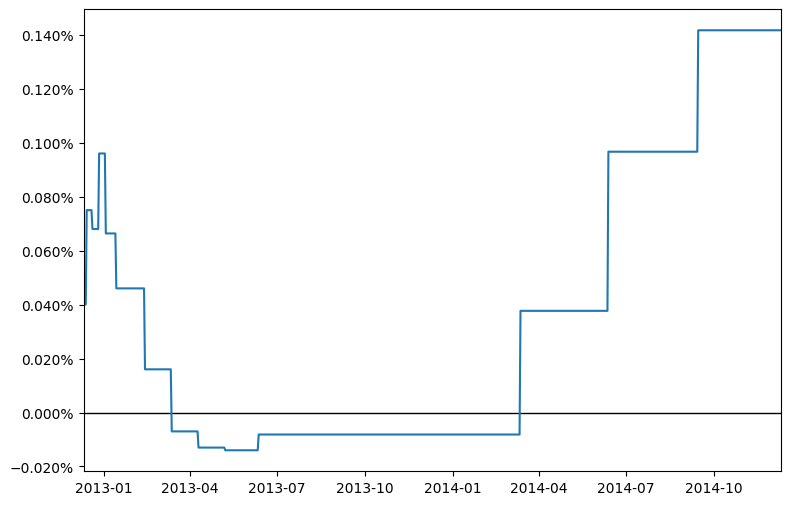

In [60]:
rates_c = [
    curve.getForwardRate(periodStart=periodStart.to_date(), periodEnd=periodEnd.to_date()).realPart
    for periodStart, periodEnd in zip(datesToPlot[:-1], datesToPlot[1:])
]
ax = plt.figure(figsize=(9, 6)).add_subplot(1, 1, 1)
ax.axhline(0.0, linewidth=1, color="black")
ax.set_xlim(min(datesToPlot).to_date(), max(datesToPlot).to_date())
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.plot_date([d.to_date() for d in datesToPlot[:-1]], rates_c, "-");